##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API를 사용하는 옵티마이저

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/core/optimizers_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 소개

이 노트북은 [TensorFlow Core 하위 수준 API](https://www.tensorflow.org/guide/core)를 사용하여 사용자 정의 옵티마이저 프로그램을 만드는 프로세스를 소개합니다. TensorFlow Core 및 기본 사용 사례에 대해 자세히 알아보려면 [Core API 개요](https://www.tensorflow.org/guide/core)를 방문하세요.

[Keras 옵티마이저](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) 모듈은 다양한 일반 훈련 목적에 사용할 것이 권장되는 최적화 도구입니다. 여기에는 미리 빌드한 다양한 옵티마이저 도구와 사용자 정의 설정에 사용하는 하위 클래스 기능이 포함됩니다. Keras 옵티마이저는 Core API로 빌드한 사용자 정의 레이어, 모델 및 훈련 루프와도 호환됩니다. 이러한 사전 구축 및 사용자 정의 가능한 옵티마이저 프로그램은 대부분의 경우에 적합하지만 Core API를 사용하면 최적화 프로세스를 완벽하게 제어할 수 있습니다. 예를 들어, SAM(선명도 인식 최소화)과 같은 기술을 사용하려면 모델과 옵티마이저를 결합해야 하는데, 이는 ML 옵티마이저의 기존 정의에 맞지 않습니다. 이 가이드는 Core API를 사용하여 처음부터 사용자 정의 옵티마이저를 구축하는 프로세스를 안내하고 옵티마이저의 구조, 구현 및 동작을 완전히 제어할 수 있는 권한을 제공합니다.

## 옵티마이저 개요

옵티마이저는 모델의 훈련 가능한 매개변수와 관련된 손실 함수를 최소화하는 데 사용하는 알고리즘입니다. 가장 간단한 최적화 기술은 손실 함수의 가장 가파른 하강 방향으로 단계를 진행하며 모델의 매개변수를 반복적으로 업데이트하는 경사 하강입니다. 단계 크기는 그래디언트 크기에 정비례하며, 그래디언트가 너무 크거나 작으면 문제가 될 수 있습니다. Adam, Adagrad 및 RMSprop과 같은 다른 많은 그래디언트 기반 옵티마이저는 메모리 효율성과 빠른 수렴을 위해 그래디언트의 다양한 수학적 속성을 활용합니다.

## 설치하기

In [2]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [3]:
import tensorflow as tf
print(tf.__version__)
# set random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 21:34:39.037395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:34:39.037520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:34:39.037530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


## 경사 하강

기본 옵티마이저 클래스에는 그래디언트 목록을 제공한 변수 목록을 업데이트하는 초기화 메서드와 함수가 있어야 합니다. 학습율에 따라 조정된 그래디언트를 빼서 각 변수를 업데이트하는 기본 경사 하강 옵티마이저를 구현하는 것으로 시작합니다.

In [4]:
class GradientDescent(tf.Module):

  def __init__(self, learning_rate=1e-3):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables
    for grad, var in zip(grads, vars):
      var.assign_sub(self.learning_rate*grad)

이 옵티마이저를 테스트하려면 단일 변수 $x$를 최소화하는 샘플 손실 함수를 생성해야 합니다. 매개변수 값을 최소화하기 위해 다음과 같이 그래디언트 함수를 계산하고 풀이합니다.

$$L = 2x^4 + 3x^3 + 2$$

$$\frac{dL}{dx} = 8x^3 + 9x^2$$

$\frac{dL}{dx}$는 안장점이 $x = 0$이고 전역 최솟값이 $x = - \frac{9}{8}$일 때 0 입니다. 따라서 손실 함수는 $x^\star = - \frac{9}{8}$일 때 최적화됩니다.

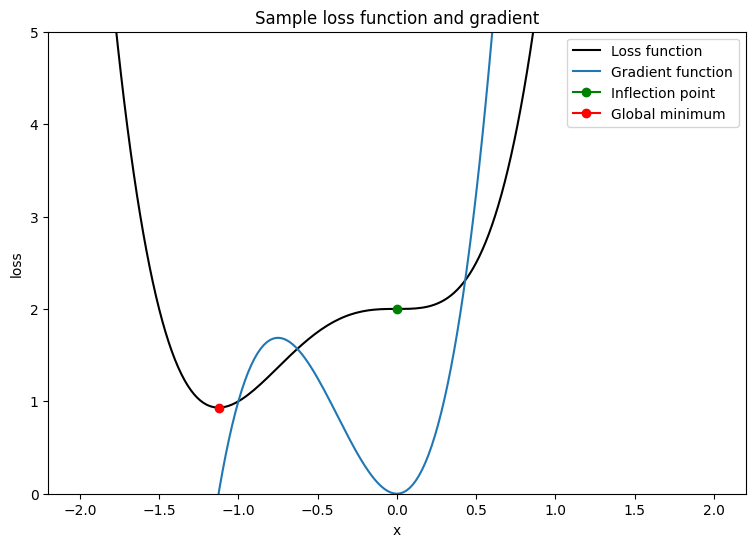

In [5]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)

def loss(x):
  return 2*(x**4) + 3*(x**3) + 2

def grad(f, x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    result = f(x)
  return tape.gradient(result, x)

plt.plot(x_vals, loss(x_vals), c='k', label = "Loss function")
plt.plot(x_vals, grad(loss, x_vals), c='tab:blue', label = "Gradient function")
plt.plot(0, loss(0),  marker="o", c='g', label = "Inflection point")
plt.plot(-9/8, loss(-9/8),  marker="o", c='r', label = "Global minimum")
plt.legend()
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("loss")
plt.title("Sample loss function and gradient");

단일 변수 손실 함수를 사용하여 옵티마이저의 수렴을 테스트하는 함수를 작성합니다. 타임스텝 $t$에서 업데이트된 매개변수의 값이 타임스텝 $t-1$에서 유지된 값과 같으면 수렴을 달성했다고 가정합니다. 설정한 반복 횟수를 완료하면 테스트를 종료하고 프로세스 중에 폭주하는 그래디언트를 추적합니다. 최적화 알고리즘을 제대로 활용하려면 매개변수를 나쁘게 초기화해야 합니다. 위의 예제에서 $x = 2$는 가파른 그래디언트를 포함하고 있고 변곡점으로 이어지기 때문에 좋은 선택입니다.

In [6]:
def convergence_test(optimizer, loss_fn, grad_fn=grad, init_val=2., max_iters=2000):
  # Function for optimizer convergence test
  print(optimizer.title)
  print("-------------------------------")
  # Initializing variables and structures
  x_star = tf.Variable(init_val)
  param_path = []
  converged = False

  for iter in range(1, max_iters + 1):
    x_grad = grad_fn(loss_fn, x_star)

    # Case for exploding gradient
    if tf.math.is_nan(x_grad):
      print(f"Gradient exploded at iteration {iter}\n")
      return []

    # Updating the variable and storing its old-version
    x_old = x_star.numpy()
    optimizer.apply_gradients([x_grad], [x_star])
    param_path.append(x_star.numpy())

    # Checking for convergence
    if x_star == x_old:
      print(f"Converged in {iter} iterations\n")
      converged = True
      break
      
  # Print early termination message
  if not converged:
    print(f"Exceeded maximum of {max_iters} iterations. Test terminated.\n")
  return param_path

1e-3, 1e-2, 1e-1 학습률에 대한 경사 하강 옵티마이저의 수렴을 테스트합니다.

In [7]:
param_map_gd = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_gd[learning_rate] = (convergence_test(
      GradientDescent(learning_rate=learning_rate), loss_fn=loss))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



손실 함수의 등고선도에서 매개변수의 경로를 시각화합니다.

In [8]:
def viz_paths(param_map, x_vals, loss_fn, title, max_iters=2000):
  # Creating a controur plot of the loss function
  t_vals = tf.range(1., max_iters + 100.)
  t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
  loss_grid = tf.math.log(loss_fn(x_grid))
  plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading='nearest')
  colors = ['r', 'w', 'c']
  # Plotting the parameter paths over the contour plot
  for i, learning_rate in enumerate(param_map):
    param_path = param_map[learning_rate]
    if len(param_path) > 0:
      x_star = param_path[-1]
      plt.plot(t_vals[:len(param_path)], param_path, c=colors[i])
      plt.plot(len(param_path), x_star, marker='o', c=colors[i], 
              label = f"x*: learning rate={learning_rate}")
  plt.xlabel("Iterations")
  plt.ylabel("Parameter value")
  plt.legend()
  plt.title(f"{title} parameter paths")

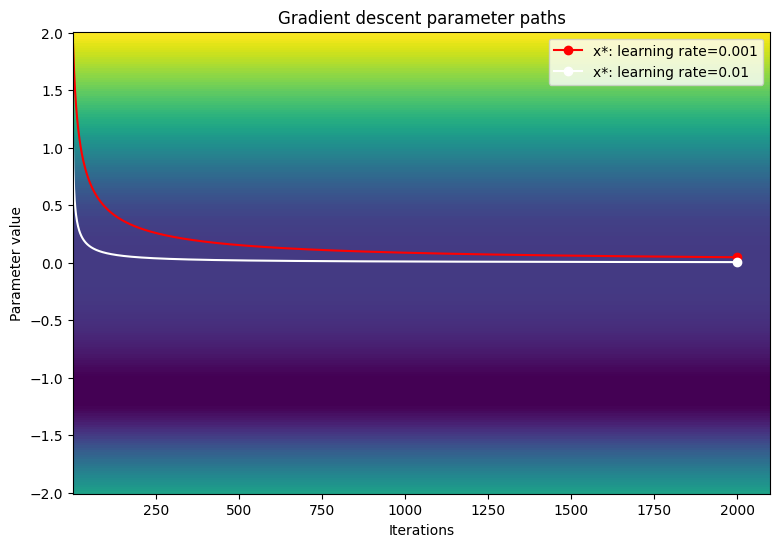

In [9]:
viz_paths(param_map_gd, x_vals, loss, "Gradient descent")

더 작은 학습률을 사용하면 경사 하강이 변곡점에서 멈춘 것처럼 보입니다. 훈련 속도를 높이면 더 큰 단계 크기로 인해 고원 영역 주변에서 더 빠르게 이동할 수도 있습니다. 다만 손실 함수가 극도로 가파른 경우 초기 반복에서 그래디언트가 폭주할 위험이 있습니다.

## 모멘텀이 있는 경사 하강

모멘텀이 있는 경사 하강은 그래디언트를 사용하여 변수를 업데이트할 뿐만 아니라 이전 업데이트를 기반으로 하는 변수 위치 변경도 포함합니다. 모멘텀 매개변수는 타임스텝 $t-1$의 업데이트가 타임스텝 $t$의 업데이트에 미치는 영향 수준을 결정합니다. 모멘텀을 누적하면 기본 경사 하강보다 빠르게 고원 영역을 지나도록 변수를 이동할 수 있습니다. 모멘텀 업데이트 규칙은 다음과 같습니다.

$$\Delta_x^{[t]} = lr \cdot L^\prime(x^{[t]}) + p \cdot \Delta_x^{[t-1]}$$

$$x^{[t]} = x^{[t-1]} - \Delta_x^{[t]}$$

여기서,

- $x$: 최적화하는 변수
- $\Delta_x$: $x$에서 변경
- $lr$: 학습률
- $L^\prime(x)$: x에 대한 손실 함수의 그래디언트
- $p$: 모멘텀 매개변수

In [10]:
class Momentum(tf.Module):

  def __init__(self, learning_rate=1e-3, momentum=0.7):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.change = 0.
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables 
    for grad, var in zip(grads, vars):
      curr_change = self.learning_rate*grad + self.momentum*self.change
      var.assign_sub(curr_change)
      self.change = curr_change

1e-3, 1e-2, 1e-1 학습률에 대한 모멘텀 옵티마이저의 수렴을 테스트합니다.

In [11]:
param_map_mtm = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_mtm[learning_rate] = (convergence_test(
      Momentum(learning_rate=learning_rate),
      loss_fn=loss, grad_fn=grad))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Converged in 80 iterations

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



손실 함수의 등고선도에서 매개변수의 경로를 시각화합니다.

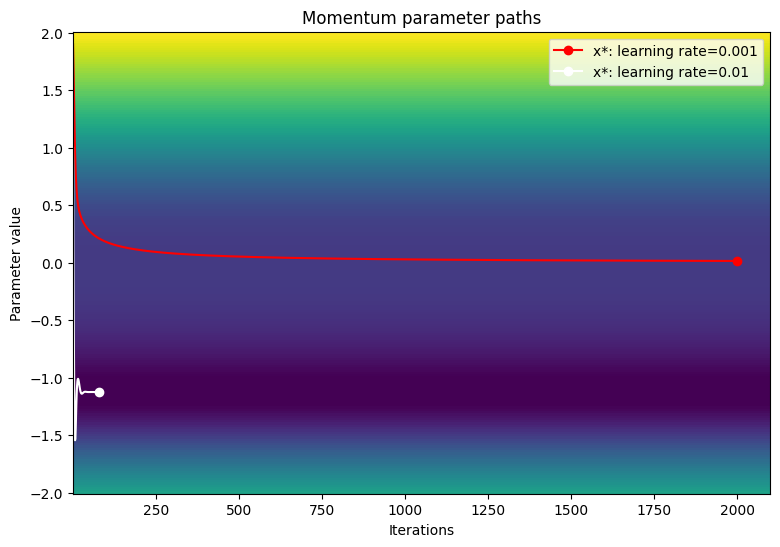

In [12]:
viz_paths(param_map_mtm, x_vals, loss, "Momentum")

## Adam(적응적 모멘트 추정)

Adam(적응적 모멘트 추정) 알고리즘은 모멘텀과 RMSprop(제곱평균제곱근 전파)의 두 가지 주요 경사 하강을 활용하는 효율적이고 고도로 일반화할 수 있는 최적화 기술입니다. 모멘텀은 감소 매개변수와 함께 첫 번째 모멘트(그래디언트의 합계)를 사용하여 경사 하강을 가속화하는 데 도움이 됩니다. RMSprop도 비슷하지만 RMSprop은 두 번째 모멘트(그래디언트 제곱의 합)를 활용합니다.

Adam 알고리즘은 첫 번째 모멘트와 두 번째 모멘트를 모두 결합하여 보다 일반화할 수 있는 업데이트 규칙을 제공합니다. 변수 $x$의 부호는 $\frac{x}{\sqrt{x^2}}$를 계산하여 결정할 수 있습니다. Adam 옵티마이저는 이러한 사실을 사용하여 효과적으로 평활화한 부호인 업데이트 단계를 계산합니다. 옵티마이저는 $\frac{x}{\sqrt{x^2}}$를 계산하는 대신 각 변수 업데이트에 대해 $x$(첫 번째 모멘트) 및 $x^2$(두 번째 모멘트)의 평활화 버전을 계산합니다.


**Adam 알고리즘**

$\beta_1 \gets 0.9 ; \triangleright \text{literature value}$

$\beta_2 \gets 0.999 ; \triangleright \text{literature value}$

$lr \gets \text{1e-3} ; \triangleright \text{configurable learning rate}$

$\epsilon \gets \text{1e-7} ; \triangleright \text{prevents divide by 0 error}$

$V_{dv} \gets \vec {\underset{n\times1}{0}} ;\triangleright \text{stores momentum updates for each variable}$

$S_{dv} \gets \vec {\underset{n\times1}{0}} ; \triangleright \text{stores RMSP updates for each variable}$

$t \gets 1$

$\text{On iteration } t:$

$;;;; \text{For} (\frac{dL}{dv}, v) \text{ in gradient variable pairs}:$

$;;;;;;;; V_{dv_i} = \beta_1V_{dv_i} + (1 - \beta_1)\frac{dL}{dv} ; \triangleright \text{momentum update}$

$;;;;;;;; S_{dv_i} = \beta_2V_{dv_i} + (1 - \beta_2)(\frac{dL}{dv})^2 ; \triangleright \text{RMSP update}$

$;;;;;;;; v_{dv}^{bc} = \frac{V_{dv_i}}{(1-\beta_1)^t} ; \triangleright \text{momentum bias correction}$

$;;;;;;;; s_{dv}^{bc} = \frac{S_{dv_i}}{(1-\beta_2)^t} ; \triangleright \text{RMSP bias correction}$

$;;;;;;;; v = v - lr\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon} ; \triangleright \text{parameter update}$

$;;;;;;;; t = t + 1$

**알고리즘의 끝**

$V_{dv}$와 $S_{dv}$가 0으로 초기화되고 $\beta_1$ 및 $\beta_2$가 1에 가까운 경우 모멘텀과 RMSprop 업데이트는 자연스럽게 0으로 바이어스됩니다. 따라서 변수는 바이어스 수정으로 혜택을 받을 수 있습니다. 또한 바이어스 보정은 가중치가 전역 최솟값에 접근할 때 가중치의 진동을 제어하는 데 도움이 됩니다.

In [13]:
class Adam(tf.Module):
  
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads, vars):
      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
        # Bias correction
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        # Update model variables
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      # Increment the iteration counter
      self.t += 1.

경사 하강 예제에 사용한 것과 동일한 학습률로 Adam 옵티마이저의 성능을 테스트합니다. 

In [14]:
param_map_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_adam[learning_rate] = (convergence_test(
      Adam(learning_rate=learning_rate), loss_fn=loss))

Adam: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.1
-------------------------------


Converged in 1156 iterations



손실 함수의 등고선도에서 매개변수의 경로를 시각화합니다.

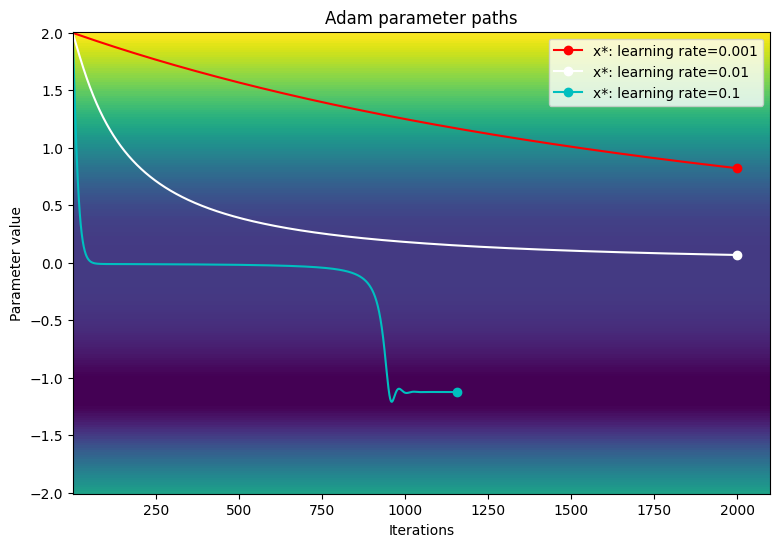

In [15]:
viz_paths(param_map_adam, x_vals, loss, "Adam")

이 특별한 예제에서 Adam 옵티마이저는 작은 학습률을 사용할 때 기존의 경사 하강에 비해 수렴 속도가 느립니다. 그러나 알고리즘은 성공적으로 고원 영역을 지나며 학습률이 높을 때 전역 최솟값으로 수렴합니다. 대형 그래디언트가 발생해도 Adam 학습률의 동적 스케일링으로 인해 그래디언트 폭주가 더 이상 문제가 되지 않습니다.

## 결론

이 노트북에서는 [TensorFlow Core API](https://www.tensorflow.org/guide/core)를 사용하여 옵티마이저를 작성하고 비교하는 기본 내용을 소개했습니다. Adam과 같은 미리 빌드된 옵티마이저는 일반화할 수 있지만 경우에 따라 일부 모델 또는 데이터세트에서는 최선의 선택이 아닐 수도 있습니다. 최적화 프로세스를 세밀하게 제어하면 ML 훈련 워크플로를 간소화하고 전반적인 성능을 개선할 수도 있습니다. 사용자 정의 옵티마이저의 더 많은 예제는 다음 문서를 참조하세요.

- 이 Adam 옵티마이저는 [멀티레이어 퍼셉트론](https://www.tensorflow.org/guide/core/mlp_core) 가이드 및 [분산 훈련]()에서 사용됩니다.
- [Model Garden](https://blog.tensorflow.org/2020/03/introducing-model-garden-for-tensorflow-2.html)에는 Core API로 작성된 다양한 [사용자 정의 옵티마이저](https://github.com/tensorflow/models/tree/master/official/modeling/optimization)가 있습니다.
